# Poker and Maze games using Reinforcement Learning



<font color="blue"> Credit: Surya Pavan Malireddy, https://github.com/ms-pavan/Poker-and-Maze-games-using-Reinforcement-Learning</font>

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [6]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        
    def greedy(self, s):
        return np.argmax(self.Q[s[0], s[1]])

    def epsilon_greed(self, e,s):
        if np.random.rand() < e:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
            
                # update self.Q table 
                self.Q[s[0],s[1],a] += alpha*(r + gamma * np.max(self.Q[s1[0],s1[1],:]) - self.Q[s[0],s[1],a])
                
                if self.env.is_goal(): # reached the goal
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        env.init(start)
        s = env.get_cur_state()
        a = np.argmax(self.Q[s[0], s[1], :])
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
            env.next(a)
            s1 = env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0], s1[1],:])
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            if env.is_goal():  # reached the goal
                break
            a = a1
        
        return trace            

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

In [7]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Initial Parameters of Gridworld

alpha = 0.1  
epsilon = 0.1  
gamma = 0.99  
maxiter = 100  
maxsteps = 1000  

### Training and Testing with GridWorld

In [8]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


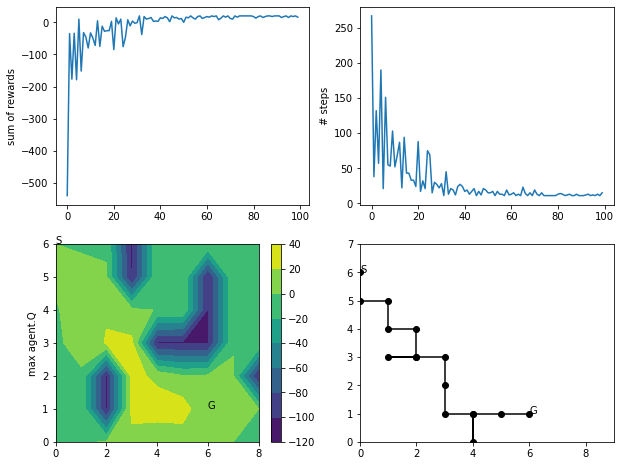

In [9]:
plot_train(agent, rtrace, steps, trace, start)

#### Trained maze with above parameter values.
#### sum of rewards plots shows total rewards obtained in each iteration. Initially, rewards are very less which indicates it failed to reach goal. Upon increase in iterations, Q values are updated and optimal path is obtained which can be observed from increase in rewards.

#### Steps explain number of steps taken to reach goal. Initially agent took greater than 200 steps to reach goal and this number gradually reduced to below 10 upon training.

#### Q values can be seen on all states in contour plot.

#### Trace plot shows the path to reach goal from a starting point in maze.

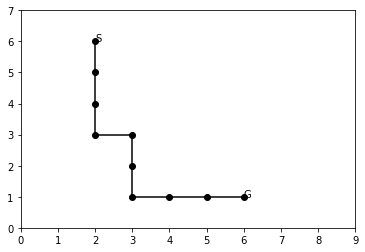

In [10]:
test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

#### [0,2] is the test state to start in maze, the path it followed to reach goal using Q table values is shown.

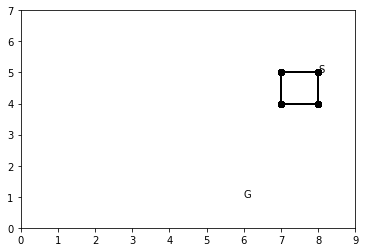

In [11]:
test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

#### [1,8] is the test state to start in maze, the path it followed to reach goal using Q table values is shown.

## Experimental outputs that show the choice of parameters. How do you choose them? 

#### Maze - Choice of alpha and epsilon vs Rewards

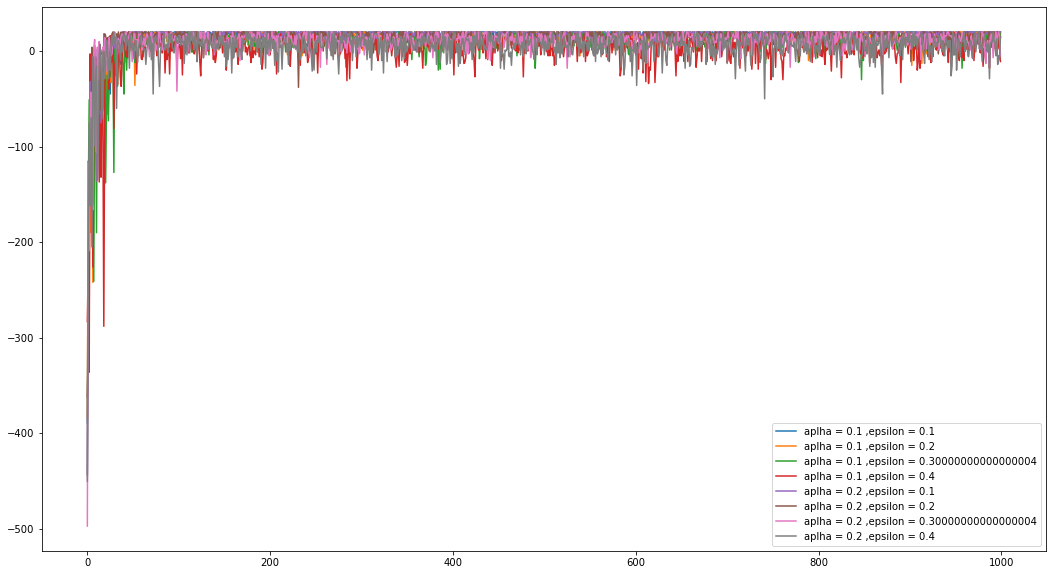

In [12]:
fig = plt.figure(figsize=(18,10));    
for _alpha in range(1,3,1):
    for _eps in range(1,5,1):
        agent = RLAgent(env)
        start = [0,0]
        rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1 *_alpha, 
                                   epsilon=0.1 *_eps, 
                                   maxiter=1000, 
                                   maxstep=1000)
        plt.plot(rtrace,label='aplha = '+str(0.1 *_alpha)+' ,epsilon = '+str(0.1 *_eps));
plt.legend();

Trained the model with alpha of 0.1,0.2 and epsilon of 0.1 to 0.4. Rewards for each iteration are plotted and select parameters that produce less negative rewards.

#### Maze - Choice of alpha and epsilon vs Steps

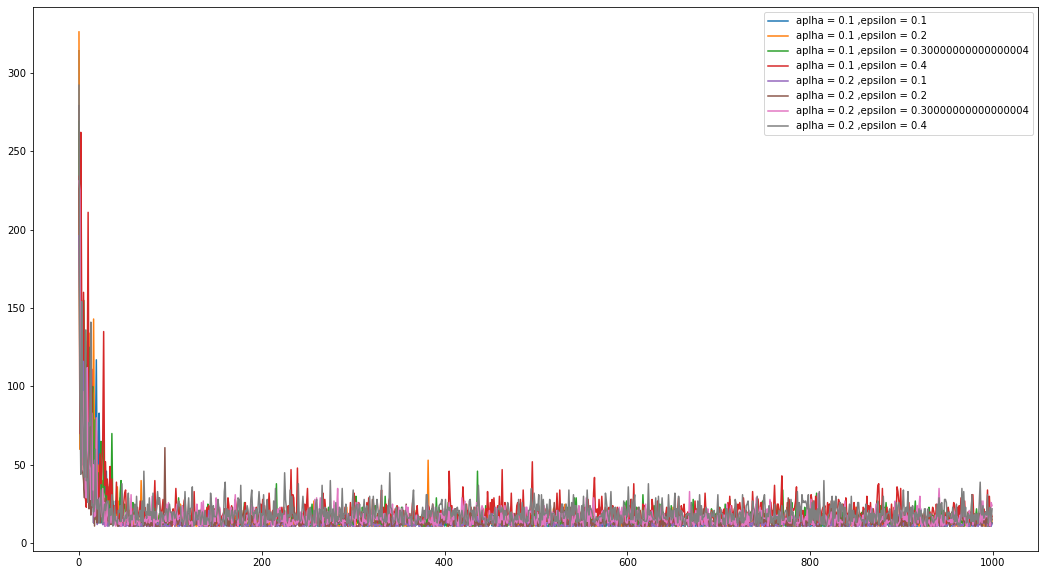

In [13]:
fig = plt.figure(figsize=(18,10));    
for _alpha in range(1,3,1):
    for _eps in range(1,5,1):
        agent = RLAgent(env)
        start = [0,0]
        rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1 *_alpha, 
                                   epsilon=0.1 *_eps, 
                                   maxiter=1000, 
                                   maxstep=1000)
        plt.plot(steps,label='aplha = '+str(0.1 *_alpha)+' ,epsilon = '+str(0.1 *_eps));
plt.legend();

Trained the model with alpha of 0.1,0.2 and epsilon of 0.1 to 0.4. Total steps for each iteration are plotted and select parameters that produce less steps.

### Selected parameters of Maze
 alpha = 0.1  
 epsilon = 0.2  
 gamma = 0.99  
 maxiter = 1000   
 maxsteps = 1000  
 
On observing above graphs, we get maximum rewards ,minimum steps for these parameters. Maze can be explored completely with optimal values and find a path from any given point.

### Output Plots

#### Maze training plots

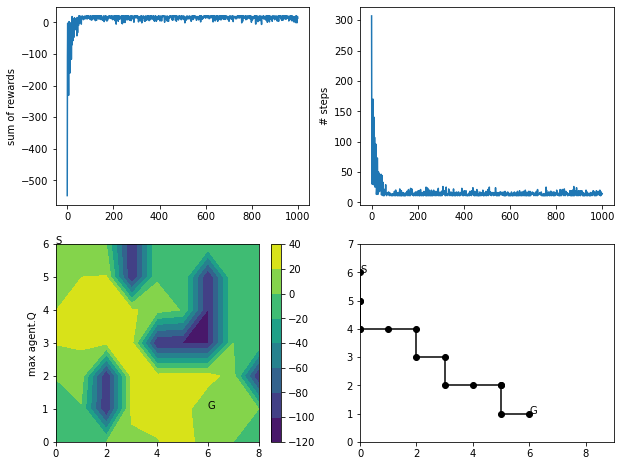

In [14]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.2, 
                                   maxiter=1000, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

We train the model with modified parameters and output plots are plotted again. This time we can see decrease in negative rewards, steps taken and path from start to goal is optimized.

#### Maze Test path

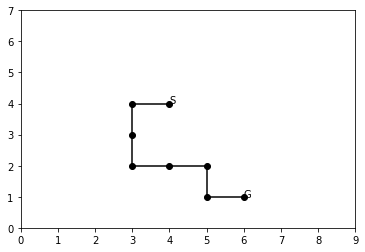

In [20]:
test_start = [2,4]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

Given a test start state of (2,3), we are able to get best path to goal.

# References

http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/notes/Note-ReinforcementLearning.ipynb
https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287

# Extra Credit

- Let us have Poker Tournament in class (Nov 6th.)!
- Top 4 (or more) students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 